# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to compare the representation of the real input data and the simulated batch data.  We will use **SVCCA** to compare these two representations.

Here, we apply Singular Vector Canonical Correlation Analysis [Raghu et al. 2017](https://arxiv.org/pdf/1706.05806.pdf) [(github)](https://github.com/google/svcca) to the UMAP and PCA representations of our batch 1 simulated dataset vs batch n simulated datasets.  The output of the SVCCA analysis is the SVCCA mean similarity score. This single number can be interpreted as a measure of similarity between our original data vs batched dataset.

Briefly, SVCCA uses Singular Value Decomposition (SVD) to extract the components explaining 99% of the variation. This is done to remove potential dimensions described by noise. Next, SVCCA performs a Canonical Correlation Analysis (CCA) on the SVD matrices to identify maximum correlations of linear combinations of both input matrices. The algorithm will identify the canonical correlations of highest magnitude across and within algorithms of the same dimensionality.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
import umap
import pickle
import warnings
warnings.filterwarnings(action='ignore')

from ggplot import *
from functions import cca_core
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# Load config file
config_file = "config_exp_1.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_PCs = d["num_PCs"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

simulated_data_file = os.path.join(
    base_dir,
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

umap_model_file = umap_model_file = os.path.join(
    base_dir,
    "models",  
    NN_architecture,
    "umap_model.pkl")

In [5]:
# Read in UMAP model
infile = open(umap_model_file, 'rb')
umap_model = pickle.load(infile)
infile.close()

In [6]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0, 
    index_col=0,
    sep='\t')

simulated_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.474494,0.696870,0.238944,0.267328,0.583896,0.163173,0.235312,0.575820,0.132366,0.400795,...,0.757839,0.279478,0.561519,0.491499,0.449728,0.677076,0.124337,0.541154,0.720271,0.433547
1,0.441185,0.550324,0.219221,0.266000,0.590521,0.201786,0.212634,0.536296,0.177473,0.313939,...,0.810853,0.320016,0.542352,0.554965,0.502701,0.587785,0.175613,0.481203,0.498466,0.438769
2,0.521074,0.543742,0.336719,0.252867,0.599334,0.291142,0.229665,0.567645,0.187659,0.430471,...,0.446711,0.463937,0.392560,0.507871,0.508629,0.474983,0.246932,0.588248,0.579252,0.413991
3,0.596203,0.551936,0.345861,0.302489,0.531909,0.258675,0.264847,0.422646,0.267940,0.474586,...,0.693343,0.364793,0.536226,0.499298,0.492214,0.415613,0.294030,0.536930,0.344359,0.429401
4,0.482794,0.633886,0.303745,0.312830,0.450920,0.218819,0.216378,0.451298,0.235343,0.466791,...,0.520269,0.356043,0.461527,0.473496,0.540051,0.382430,0.265336,0.431511,0.512582,0.530147
5,0.426684,0.701658,0.408193,0.342460,0.431087,0.437039,0.298775,0.508043,0.216968,0.542441,...,0.577298,0.251121,0.411203,0.367234,0.420593,0.295283,0.319015,0.530860,0.503682,0.435850
6,0.381678,0.589432,0.270064,0.342137,0.629668,0.250987,0.172229,0.401775,0.235665,0.338248,...,0.510384,0.377027,0.484328,0.492013,0.541812,0.344019,0.273659,0.545264,0.394876,0.499558
7,0.400522,0.636906,0.228519,0.464320,0.672855,0.236873,0.168115,0.330595,0.260448,0.323219,...,0.587457,0.363698,0.611703,0.467752,0.573952,0.355191,0.274361,0.565848,0.402649,0.593904
8,0.501997,0.601793,0.210271,0.388671,0.570547,0.236643,0.168893,0.323124,0.232122,0.416512,...,0.779672,0.276626,0.620640,0.533968,0.474002,0.257428,0.229648,0.610038,0.489887,0.498294
9,0.428152,0.623297,0.294565,0.350955,0.502915,0.277763,0.251814,0.494694,0.219805,0.450239,...,0.482579,0.388641,0.509143,0.414734,0.456965,0.407720,0.275378,0.559786,0.527550,0.514114


## Calculate Similarity using high dimensional (5K) batched data

In [7]:
%%time
# Calculate similarity using SVCCA

# Store svcca scores
output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Use trained model to encode expression data into SAME latent space
    original_data_df =  batch_1
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_df =  batch_other
    
    # Check shape: ensure that the number of samples is the same between the two datasets
    if original_data_df.shape[0] != batch_data_df.shape[0]:
        diff = original_data_df.shape[0] - batch_data_df.shape[0]
        original_data_df = original_data_df.iloc[:-diff,:]
    
    # SVCCA
    svcca_results = cca_core.get_cca_similarity(original_data_df.T,
                                          batch_data_df.T,
                                          verbose=False)
    
    output_list.append(np.mean(svcca_results["cca_coef1"]))

Calculating SVCCA score for 1 batch vs 1 batches..
Calculating SVCCA score for 1 batch vs 2 batches..
Calculating SVCCA score for 1 batch vs 5 batches..
Calculating SVCCA score for 1 batch vs 10 batches..
Calculating SVCCA score for 1 batch vs 20 batches..
Calculating SVCCA score for 1 batch vs 50 batches..
Calculating SVCCA score for 1 batch vs 100 batches..
Calculating SVCCA score for 1 batch vs 500 batches..
Calculating SVCCA score for 1 batch vs 1000 batches..
Calculating SVCCA score for 1 batch vs 2000 batches..
Calculating SVCCA score for 1 batch vs 3000 batches..
Calculating SVCCA score for 1 batch vs 6000 batches..
CPU times: user 35min 15s, sys: 5min 39s, total: 40min 54s
Wall time: 9min 31s


In [8]:
# Convert output to pandas dataframe
svcca_raw_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
svcca_raw_df

,svcca_mean_similarity
1,0.995877
2,0.541352
5,0.569670
10,0.571708
20,0.572152
50,0.571929
100,0.572532
500,0.573037
1000,0.572765
2000,0.573110


In [9]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = simulated_data.shape[0]

for i in range(num_samples):
    row = list(simulated_data.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, index=simulated_data.index, columns=simulated_data.columns)
shuffled_simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.241386,0.402257,0.248498,0.138983,0.281321,0.368983,0.415709,0.388722,0.814854,0.236955,...,0.446226,0.475811,0.305363,0.116942,0.592207,0.273776,0.195969,0.113580,0.458955,0.622206
1,0.223560,0.509262,0.274514,0.278280,0.234895,0.374157,0.104009,0.189536,0.681980,0.352704,...,0.204581,0.186414,0.853353,0.609078,0.721962,0.507601,0.173726,0.675133,0.646617,0.462790
2,0.290861,0.449645,0.506355,0.509598,0.555838,0.258528,0.438649,0.377589,0.455247,0.493701,...,0.399989,0.232601,0.414148,0.238453,0.201358,0.680870,0.308055,0.379185,0.380219,0.330099
3,0.182675,0.685023,0.449600,0.276972,0.442969,0.339968,0.386469,0.261094,0.174565,0.602919,...,0.312858,0.422406,0.405815,0.711816,0.642572,0.415431,0.283052,0.274896,0.364454,0.436084
4,0.359666,0.442325,0.418003,0.304205,0.379381,0.319710,0.415753,0.542512,0.501125,0.243813,...,0.323731,0.557872,0.482986,0.425119,0.625209,0.759142,0.532774,0.394323,0.522555,0.442546


In [10]:
%%time
# SVCCA
svcca_results = cca_core.get_cca_similarity(simulated_data.T,
                                      shuffled_simulated_data.T,
                                      verbose=False)

print(np.mean(svcca_results["cca_coef1"]))

0.5798155477292326
CPU times: user 2min 37s, sys: 21.8 s, total: 2min 58s
Wall time: 32.5 s


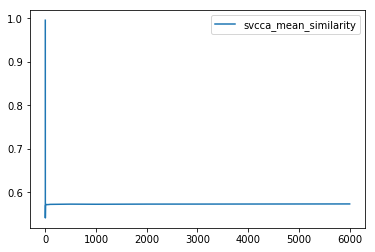

In [11]:
# Plot
svcca_raw_df.plot()

## Calculate Similarity using PCA projection of batched data

In [12]:
"""
output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    pca = PCA(n_components=num_PCs)

    # Use trained model to encode expression data into SAME latent space
    original_data_PCAencoded = pca.fit_transform(batch_1)


    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,
                                         index=batch_1.index
                                         )
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        sep='\t',
        index_col=0)
    
    print("Using batch {}".format(i))
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_PCAencoded = pca.fit_transform(batch_other)
    
    
    batch_data_PCAencoded_df = pd.DataFrame(batch_data_PCAencoded,
                                         index=batch_other.index
                                         )
        
    # Check shape
    if original_data_PCAencoded_df.shape[0] != batch_data_PCAencoded_df.shape[0]:
        diff = original_data_PCAencoded_df.shape[0] - batch_data_PCAencoded_df.shape[0]
        original_data_PCAencoded_df = original_data_PCAencoded_df.iloc[:-diff,:]
    
    # SVCCA
    svcca_results = cca_core.get_cca_similarity(original_data_PCAencoded_df.T,
                                          batch_data_PCAencoded_df.T,
                                          verbose=False)
    
    output_list.append(np.mean(svcca_results["cca_coef1"]))

# Convert output to pandas dataframe
svcca_pca_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
svcca_pca_df
"""

'\noutput_list = []\n\nfor i in num_batches:\n    print(\'Calculating SVCCA score for 1 batch vs {} batches..\'.format(i))\n    \n    # Get batch 1\n    batch_1_file = os.path.join(\n        batch_dir,\n        "Batch_1.txt")\n\n    batch_1 = pd.read_table(\n        batch_1_file,\n        header=0,\n        sep=\'\t\',\n        index_col=0)\n\n    # PCA projection\n    pca = PCA(n_components=num_PCs)\n\n    # Use trained model to encode expression data into SAME latent space\n    original_data_PCAencoded = pca.fit_transform(batch_1)\n\n\n    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,\n                                         index=batch_1.index\n                                         )\n    \n    # All batches\n    batch_other_file = os.path.join(\n        batch_dir,\n        "Batch_"+str(i)+".txt")\n\n    batch_other = pd.read_table(\n        batch_other_file,\n        header=0,\n        sep=\'\t\',\n        index_col=0)\n    \n    print("Using batch {}".fo

In [13]:
"""
# Plot
svcca_pca_df.plot()"""

'\n# Plot\nsvcca_pca_df.plot()'

## Manually compute similarity by applying CCA to PC batched data

In [14]:
"""
cca = CCA(n_components=1)

output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    pca = PCA(n_components=num_PCs)

    # Use trained model to encode expression data into SAME latent space
    original_data_PCAencoded = pca.fit_transform(batch_1)


    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,
                                         index=batch_1.index
                                         )
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        sep='\t',
        index_col=0)
    
    print("Using batch {}".format(i))
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_PCAencoded = pca.fit_transform(batch_other)
    
    
    batch_data_PCAencoded_df = pd.DataFrame(batch_data_PCAencoded,
                                         index=batch_other.index
                                         )
        
    # Check shape
    if original_data_PCAencoded_df.shape[0] != batch_data_PCAencoded_df.shape[0]:
        diff = original_data_PCAencoded_df.shape[0] - batch_data_PCAencoded_df.shape[0]
        original_data_PCAencoded_df = original_data_PCAencoded_df.iloc[:-diff,:]
    
    # CCA
    U_c, V_c = cca.fit_transform(original_data_PCAencoded_df, batch_data_PCAencoded_df)
    result = np.corrcoef(U_c.T, V_c.T)[0,1]
    
    output_list.append(result)

# Convert output to pandas dataframe
pca_cca_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
pca_cca_df
"""

'\ncca = CCA(n_components=1)\n\noutput_list = []\n\nfor i in num_batches:\n    print(\'Calculating SVCCA score for 1 batch vs {} batches..\'.format(i))\n    \n    # Get batch 1\n    batch_1_file = os.path.join(\n        batch_dir,\n        "Batch_1.txt")\n\n    batch_1 = pd.read_table(\n        batch_1_file,\n        header=0,\n        sep=\'\t\',\n        index_col=0)\n\n    # PCA projection\n    pca = PCA(n_components=num_PCs)\n\n    # Use trained model to encode expression data into SAME latent space\n    original_data_PCAencoded = pca.fit_transform(batch_1)\n\n\n    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,\n                                         index=batch_1.index\n                                         )\n    \n    # All batches\n    batch_other_file = os.path.join(\n        batch_dir,\n        "Batch_"+str(i)+".txt")\n\n    batch_other = pd.read_table(\n        batch_other_file,\n        header=0,\n        sep=\'\t\',\n        index_col=0)\n    \n

In [15]:
"""
# Plot
pca_cca_df.plot()"""

'\n# Plot\npca_cca_df.plot()'